In [1]:
import random

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch as th
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import matplotlib.pyplot as plt

import dgl
from dgl.nn.pytorch import GraphConv, SAGEConv, GATConv, GatedGraphConv

import warnings

Using backend: pytorch


C:\Users\wilbert osmond\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\wilbert osmond\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


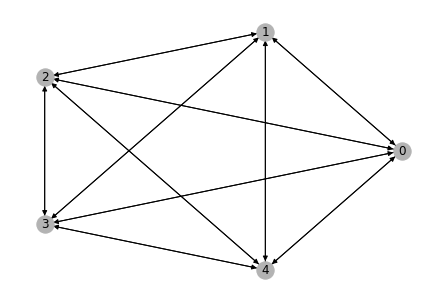

In [2]:
# Construct Graph
# option: fully-connected network
def ED_graph():
    # One for source endpoints, while the other for destination endpoints.
    src = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4])
    dst = np.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])
    # Construct a DGL Graph
    return dgl.graph((src, dst))
G = ED_graph()

nx_G = G.to_networkx()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])
plt.show()

## 0. Clean Data

In [3]:
# load data
df=pd.read_excel("Data/df_EMA.xlsx").dropna()

# Drop all time that is not day 1-18
df=df.drop(df[df['time'] == 'demo_arm_1'].index)
df=df.drop(df[df['time'] == 'setup_arm_1'].index)
day_exclude = ['day_47','day_48','day_49','day_50','day_51','day_52','day_53']
for day in day_exclude:
    df=df.drop(df[df['time'].str.contains(day)].index)

# Split column time into two separate columns: (1) day, (2) beepvar
df_time = df['time'].str.split("_", n=4, expand=True)
df['day'] = df_time[1]
df['beepvar'] = df_time[3] 
df.drop(columns =['time'], inplace=True)

df['day'] = pd.to_numeric(df['day'])
df=df.sort_values(['ID','day'])

# Clean ID
df['ID'] = df['ID'].str.strip("DH")
df.set_index('ID', inplace=True)

# Rearrange columns
df=df[['day','beepvar','dh51','dh52','dh53','dh54','dh58']]

#df

In [4]:
# Filter out ID's with NA<10% and group ID into array
ID_list = df.index.unique()
df_individuals = []
for ID in ID_list:
    if df[df.index==ID].shape[0] >= 0.9*(18*4):
        df_individuals.append(df[df.index==ID])

print(len(df_individuals))

39


## 1. Pre-Process Data

In [5]:
# Add targets from t+1 input features to new columns in row t
for idx, df_individual in enumerate(df_individuals):
    dh = [51,52,53,54,58]
    for item in dh:
        df_individual[f'target_dh{item}'] = df_individual[f'dh{item}'].shift(-1)
    df_individuals[idx] = df_individual.dropna() # drop NA (i.e. last row)
#df_individuals[0]

C:\Users\wilbert osmond\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [6]:
def preprocess_data(df_individual):
    df_features = df_individual.iloc[:,[2,3,4,5,6,7,8,9,10,11]]
    df_features = np.array(df_features.values)
    
    # Split data into 80% train, 20% test
    train, test = train_test_split(df_features, test_size=0.2, random_state=42)
    
    # Normalize train and test
    sc = Normalizer().fit(train)
    train = th.tensor(sc.transform(train)).type(th.FloatTensor)
    test = th.tensor(sc.transform(test)).type(th.FloatTensor)
    
    # Return train and test as dictionary
    dataset = dict();
    dataset['X_train'] = train[:,:5]
    dataset['Y_train'] = train[:,5:10]
    dataset['X_test'] = test[:,:5]
    dataset['Y_test'] = test[:,5:10]
    return dataset

X_train = preprocess_data(df_individuals[0])['X_train']
Y_train = preprocess_data(df_individuals[0])['Y_train']
X_test = preprocess_data(df_individuals[0])['X_test']
Y_test = preprocess_data(df_individuals[0])['Y_test']
#X_test

In [7]:
# Hot encode node feature into vector for each t
def one_hot_feature(features):
    inputs = []
    for t in range(features.shape[0]):
        embed = th.zeros(features.shape[1],features.shape[1])
        for h in range(features.shape[1]):
            embed[h][h] = features[t][h]
        inputs.append(embed)
    return(inputs) # features in diagonal

# Hot encode X_train and X_test
one_hot_Xtrain = one_hot_feature(X_train)
one_hot_Xtest = one_hot_feature(X_test)
#one_hot_Xtest

## 3. Train GNN

In [8]:
# Define GraphSAGE model that contains two GraphSAGE layers
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, aggregator):
        super(GraphSAGE, self).__init__()
        self.sage1 = SAGEConv(in_feats, hidden_size, aggregator)
        self.sage2 = SAGEConv(hidden_size, num_classes, aggregator)

    def forward(self, g, inputs):
        x = F.relu(self.sage1(g, inputs))
        x = self.sage2(g, x)
        return x

### Train 1 (72 timepoints)

In [14]:
# Train and test GNN for each participant
all_SAGE_train_loss = []
all_SAGE_test_loss = []
for df_individual in df_individuals:
    # Initialize preprocessed X and Y train data
    X_train = preprocess_data(df_individual)['X_train']
    one_hot_Xtrain = one_hot_feature(X_train)
    Y_train = preprocess_data(df_individual)['Y_train']
    
    th.manual_seed(0)
    modelSAGE = GraphSAGE(5,3,5,'lstm')
    optimizer = th.optim.Adam(modelSAGE.parameters(), lr=0.0001)
    
    # Train GNN
    SAGE_train_loss = []
    for epoch in range(25):
        mean_loss = []
        for t in range(len(one_hot_Xtrain)-1):
            logits = modelSAGE(G, one_hot_Xtrain[t]) 
            loss = F.mse_loss(th.mean(logits,0), Y_train[t]) # compare logits vs targets (i.e. features at t+1)
            optimizer.zero_grad() # clear previous gradients
            loss.backward() # backpropagation
            optimizer.step()
            mean_loss.append(loss.item())
        SAGE_train_loss.append(np.mean(mean_loss))
    train_loss = SAGE_train_loss[len(SAGE_train_loss)-1]
    all_SAGE_train_loss.append(train_loss) # loss of last train epoch
    
    # Initialize preprocessed X and Y test data
    X_test = preprocess_data(df_individual)['X_test']
    one_hot_Xtest = one_hot_feature(X_test)
    Y_test = preprocess_data(df_individual)['Y_test']
    
    # Test GNN
    SAGE_test_loss = []
    for t in range(len(one_hot_Xtest)-1):
        logits = modelSAGE(G, one_hot_Xtest[t])
        loss = F.mse_loss(th.mean(logits,0), Y_test[t])
        SAGE_test_loss.append(loss.item())
    test_loss = np.mean(SAGE_test_loss)
    all_SAGE_test_loss.append(test_loss) # mean loss of predictions
    
    print('participant = %s | Train Loss: %.4f | Test Loss: %.4f | Test > Train:  %.4f' % 
          (df_individual.index[0], train_loss, test_loss, test_loss-train_loss))

participant = 002 | Train Loss: 0.0068 | Test Loss: 0.0088 | Test > Train:  0.0020
participant = 003 | Train Loss: 0.0026 | Test Loss: 0.0037 | Test > Train:  0.0011
participant = 005 | Train Loss: 0.0052 | Test Loss: 0.0077 | Test > Train:  0.0026
participant = 007 | Train Loss: 0.0025 | Test Loss: 0.0032 | Test > Train:  0.0008
participant = 008 | Train Loss: 0.0102 | Test Loss: 0.0060 | Test > Train:  -0.0043
participant = 011 | Train Loss: 0.0044 | Test Loss: 0.0072 | Test > Train:  0.0028
participant = 012 | Train Loss: 0.0072 | Test Loss: 0.0088 | Test > Train:  0.0016
participant = 017 | Train Loss: 0.0043 | Test Loss: 0.0031 | Test > Train:  -0.0012
participant = 020 | Train Loss: 0.0142 | Test Loss: 0.0145 | Test > Train:  0.0003
participant = 021 | Train Loss: 0.0057 | Test Loss: 0.0051 | Test > Train:  -0.0006
participant = 029a | Train Loss: 0.0016 | Test Loss: 0.0008 | Test > Train:  -0.0008
participant = 059 | Train Loss: 0.0062 | Test Loss: 0.0053 | Test > Train:  -0.000

### test for patient 2

In [9]:
th.manual_seed(42)
modelSAGE = GraphSAGE(5,3,5,'lstm')
optimizer = th.optim.Adam(modelSAGE.parameters(), lr=0.0001)
SAGE_loss = []

for epoch in range(50):
    #print('Epoch %d' % (epoch))
    mean_loss = []
    SAGE_logits = []
    for t in range(len(one_hot_Xtrain)-1):
        logits = modelSAGE(G, one_hot_Xtrain[t]) 
        loss = F.mse_loss(th.mean(logits,0), Y_train[t]) # compare logits vs features at t+1
        
        mean_loss.append(loss.item())
        SAGE_logits.append(th.mean(logits,0))
        #print('t = %d | Loss: %.4f' % (t, loss.item()))
        
        optimizer.zero_grad() # clear previous gradients
        loss.backward() # backpropagation
        optimizer.step()

    SAGE_loss.append(np.mean(mean_loss))
    #print(logits)

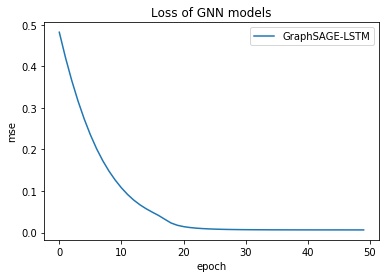

In [10]:
plt.plot(SAGE_loss, label = 'GraphSAGE-LSTM')
plt.title('Loss of GNN models')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()
plt.show()

In [11]:
# Test GNN
SAGEtestlogits = []
SAGE_test_loss = []
for t in range(len(one_hot_Xtest)-1):
    test_logits = modelSAGE(G, one_hot_Xtest[t])
    SAGEtestlogits.append(th.mean(test_logits,0))
    loss = F.mse_loss(th.mean(test_logits,0), Y_test[t])
    SAGE_test_loss.append(loss.item())
print(SAGE_test_loss)

[0.014579695649445057, 0.007680878974497318, 0.006251082755625248, 0.006481512449681759, 0.0014422591775655746, 0.009168675169348717, 0.0029918779619038105, 0.009666566736996174, 0.0036955722607672215, 0.00445473100990057, 0.004979620687663555, 0.016539661213755608, 0.0012438319390639663]


### visualization targets vs prediction

In [12]:
print('Train loss: %.6f' %np.mean(SAGE_loss[len(SAGE_loss)-1]))
print('Test loss: %.6f' %np.mean(SAGE_test_loss))

Train loss: 0.006467
Test loss: 0.006860


In [13]:
# important for visualization
def get_col(matrix):
    features = []
    for feature in range(len(matrix[0])):
        timepoint = []
        for i in range(len(matrix)):
            timepoint.append(matrix[i][feature])
        features.append(timepoint)
    return features

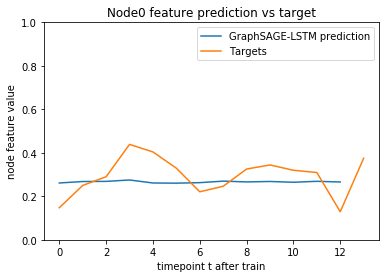

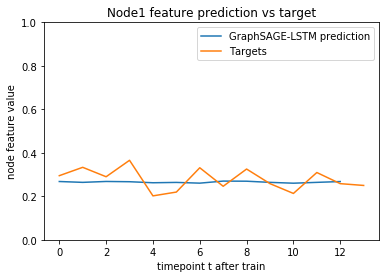

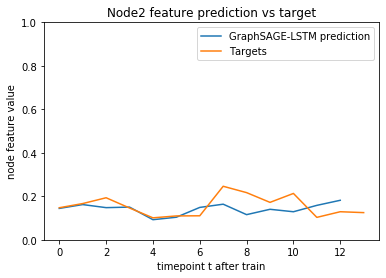

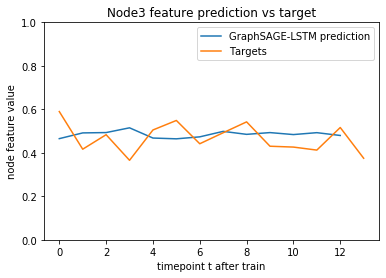

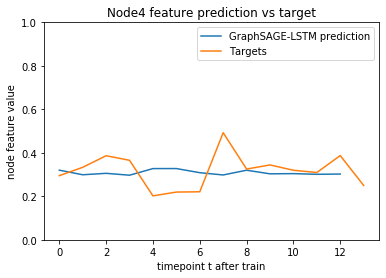

In [14]:
SAGE_test_logits = get_col(SAGEtestlogits)
X_test_logits = get_col(np.array(X_test))

for node in range(5):
    plt.plot(SAGE_test_logits[node], label = 'GraphSAGE-LSTM prediction')
    plt.plot(X_test_logits[node], label = 'Targets')
    plt.title(f'Node{node} feature prediction vs target')
    plt.xlabel('timepoint t after train')
    plt.ylabel('node feature value')
    plt.ylim(0,1)
    plt.legend()
    plt.show()

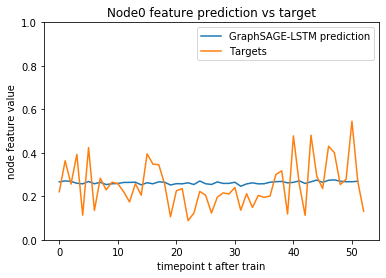

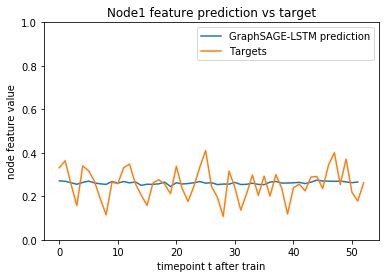

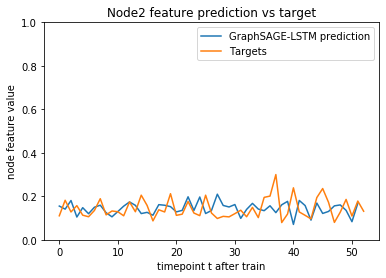

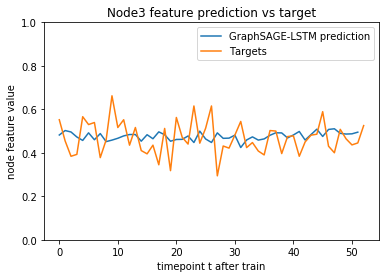

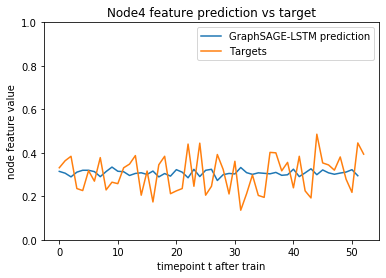

In [15]:
SAGE_train_logits = get_col(SAGE_logits)
X_train_logits = get_col(np.array(X_train))

for node in range(5):
    plt.plot(SAGE_train_logits[node], label = 'GraphSAGE-LSTM prediction')
    plt.plot(X_train_logits[node], label = 'Targets')
    plt.title(f'Node{node} feature prediction vs target')
    plt.xlabel('timepoint t after train')
    plt.ylabel('node feature value')
    plt.ylim(0,1)
    plt.legend()
    plt.show()